In [1]:
# Importing necessary libraries
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
# Filtering warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [2]:
# Set the seed for reproducibility
seed_value = 123

# Python built-in random
random.seed(seed_value)

# NumPy
np.random.seed(seed_value)

# TensorFlow
tf.random.set_seed(seed_value)

# Ensure TensorFlow and Keras use deterministic operations
os.environ['TF_DETERMINISTIC_OPS']='1'

In [3]:
# Define the base path to your data
base_path = r'C:/Users/Lavanya/Desktop/CreatED/multiclass_zip'

# Function to load images and class labels from each folder
def load_data_from_folder(folder_name, target_size=(128, 128)):
    folder_path = os.path.join(base_path, folder_name)
    classes_file = os.path.join(folder_path, '_classes.csv')
    
    # Load the classes CSV file
    if os.path.exists(classes_file):
        classes = pd.read_csv(classes_file)
    else:
        raise FileNotFoundError(f"{classes_file} not found!")
    
    # Assuming 'filename' column contains image names and the rest are the labels
    image_paths = [os.path.join(folder_path, fname) for fname in classes['filename']]
    
    
    # Convert multi-label annotations directly (no need to find max value as in multi-class)
    labels = classes.drop(columns=['filename']).values  # Keep all columns as labels
    
    # Load images as numpy arrays, grayscaling and resizing them to a consistent size
    images = []
    for img_path in image_paths:
        if os.path.exists(img_path):
            img = load_img(img_path, color_mode='grayscale', target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
        else:
            print(f"Image file not found: {img_path}")
        
    # Convert list of images to numpy array
    images = np.array(images)
    return images, np.array(labels), image_paths

In [4]:
# Load train, test, and validation data
train_images, train_labels, train_paths = load_data_from_folder('train')
test_images, test_labels, test_paths = load_data_from_folder('test')
valid_images, valid_labels, valid_paths = load_data_from_folder('valid')

In [5]:
# Checking number of images in each bucket
print(len(valid_images))
print(len(train_images))
print(len(test_images))

34
135
16


In [6]:
base_path = r'C:/Users/Lavanya/Desktop/CreatED/multiclass_zip'

# Function to plot 0's and 1's of each column from each folder
def plot_data(folder_name):
    folder_path = os.path.join(base_path, folder_name)
    classes_file = os.path.join(folder_path, '_classes.csv')
    

    df = pd.read_csv(classes_file)
    
    # Drop the filename column as it's not needed for counting
    df = df.drop(columns=['filename'])
    
    # Count the number of 0s and 1s for each column
    counts = df.apply(pd.Series.value_counts).T
    counts.columns = ['0s', '1s']
    
    # Plot the data
    counts.plot(kind='bar', stacked=False, figsize=(10, 6))
    
    # Labeling
    plt.title('Count of 0s and 1s ')
    plt.xlabel('Columns')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha="right")

    print(folder_name)
    # Show the plot
    plt.tight_layout()
    plt.show()

train


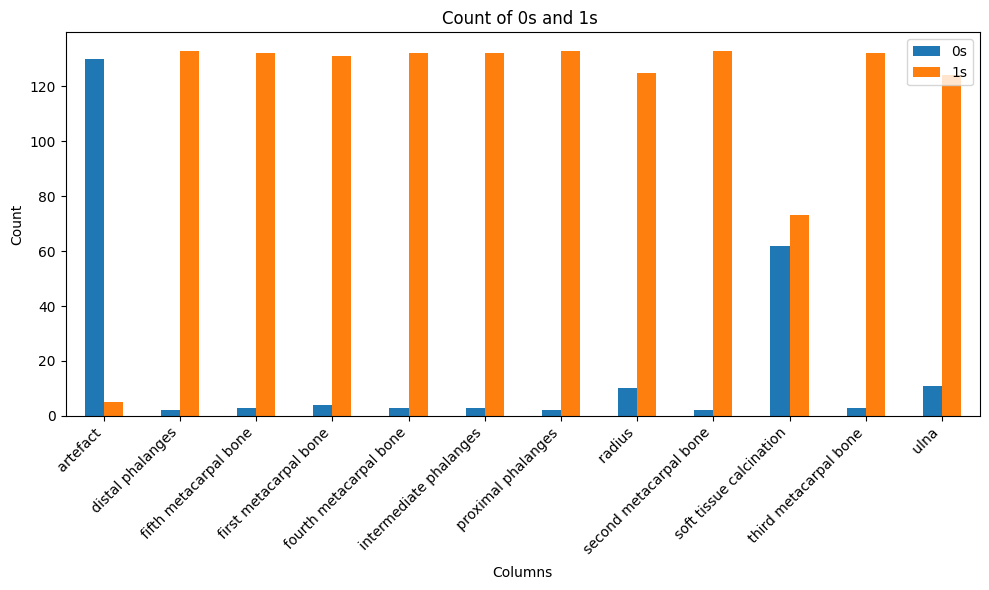

test


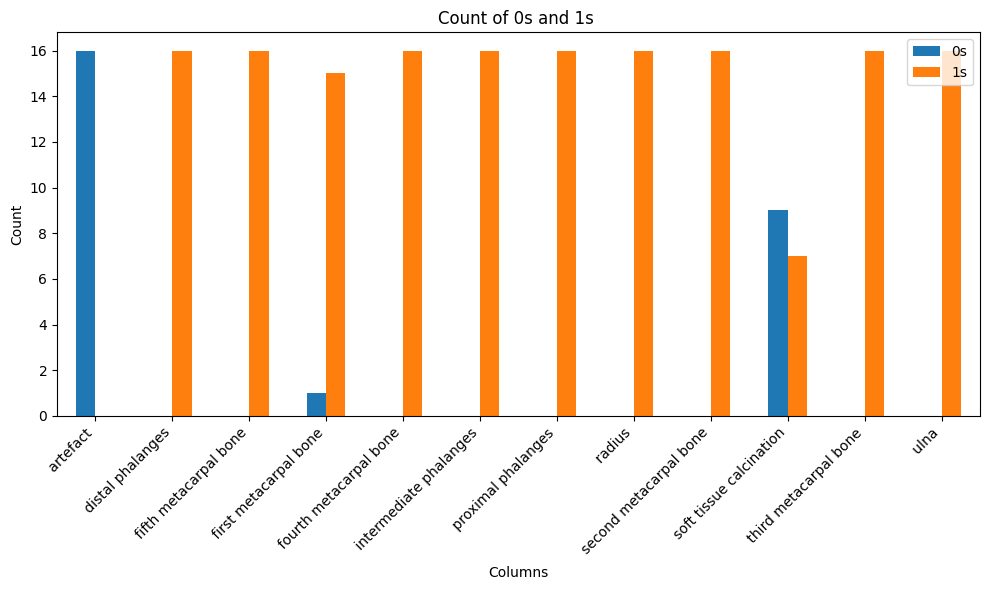

valid


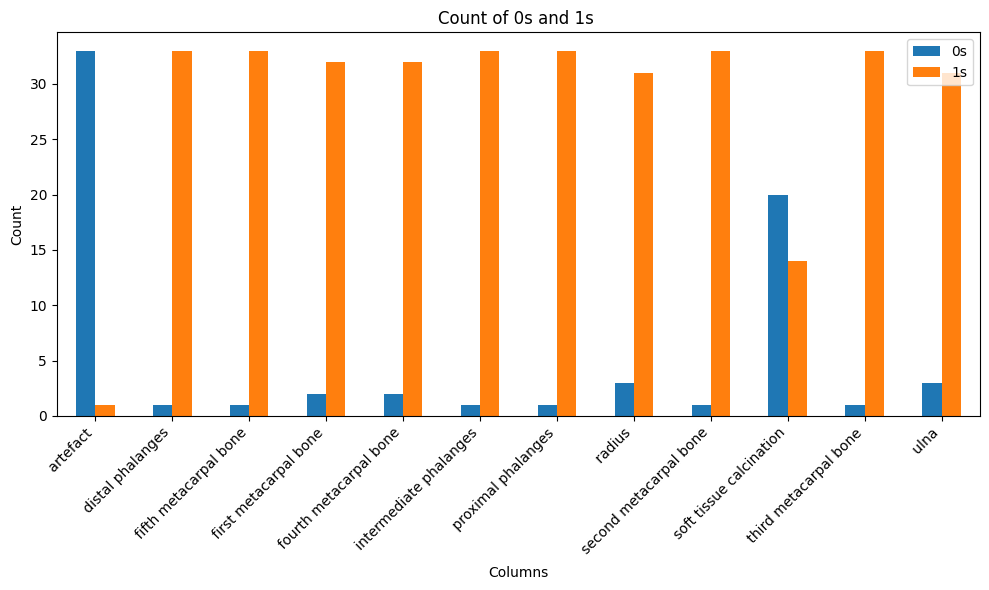

In [7]:
# Plotting 0's and 1's for each column
plot_data("train")
plot_data("test")
plot_data("valid")

## Interpretation
By plotting the data it was observed that "soft tissue calcination" had comparatively lesser positives than the rest of the classes in all three sets (train, test, and valid).

## Data Preprocessing

In [8]:
# Data Preprocessing

# Normalize image data (pixel values between 0 and 1)
train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

# Reshape X to add channel dimension (for grayscale images)
target_size=(128, 128)
train_images = train_images.reshape(train_images.shape[0], target_size[0], target_size[1], 1)
test_images = test_images.reshape(test_images.shape[0], target_size[0], target_size[1], 1)
valid_images = valid_images.reshape(valid_images.shape[0], target_size[0], target_size[1], 1)


In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

## Hyperparameter Tuning

In [10]:
# Adding class weights for ""soft tissue calcination""

# Extract the "soft tissue" label column from the labels (assuming it's at index 9 in the labels array)
soft_tissue_calcination = train_labels[:, 9]  # Adjust the index to match your dataset

# Compute class weights for soft tissue (binary classes 0 and 1)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=soft_tissue_calcination)

# Create class weight dictionary for soft tissue (index 9)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Output the class weights for verification
print("Class weights for 'soft tissue':", class_weight_dict)


Class weights for 'soft tissue': {0: 1.0887096774193548, 1: 0.9246575342465754}


## Model Building

In [11]:
# Build the CNN model with regularization and enhanced architecture
image_size = train_images.shape[1:3]  # Assuming images are of the same size
num_labels = train_labels.shape[1]    # Number of binary labels

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1),
           kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # Added extra layer for complexity
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Increased Dense layer size
    Dropout(0.5),
    
    Dense(num_labels, activation='sigmoid')  # Multi-label classification
])

# Compile the model with a lower learning rate (1e-4)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,750,476 (10.49 MB)

 Trainable params: 2,750,476 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define callbacks: Reduce learning rate on plateau and Early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the callbacks
batch_size = 32
epochs = 60

In [13]:
# Training the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size, seed=seed_value),
    validation_data=(valid_images, valid_labels),
    epochs=epochs,
    callbacks=[reduce_lr, early_stop],  # Add callbacks for learning rate adjustment and early stopping 
    class_weight={9: class_weight_dict}
)

Epoch 1/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 574ms/step - accuracy: 0.0938 - loss: 1.4831 - val_accuracy: 0.8235 - val_loss: 1.4561 - learning_rate: 1.0000e-04
Epoch 2/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.0767 - loss: 1.4477 - val_accuracy: 0.7647 - val_loss: 1.4175 - learning_rate: 1.0000e-04
Epoch 3/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.0600 - loss: 1.4101 - val_accuracy: 0.5294 - val_loss: 1.3755 - learning_rate: 1.0000e-04
Epoch 4/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.0617 - loss: 1.3743 - val_accuracy: 0.0000e+00 - val_loss: 1.3260 - learning_rate: 1.0000e-04
Epoch 5/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.0278 - loss: 1.3316 - val_accuracy: 0.0000e+00 - val_loss: 1.2608 - learning_rate: 1.0000e-04
Epoch 6/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.0464 - loss: 1.2859 - val_accuracy: 0.0000e+00 - val_loss: 1.1612 - learning_rate: 1.0000e-04
Epoch 7/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0

In [17]:
# Predict on the train set
x_pred = model.predict(train_images)
x_pred.mean() # To find the threshold

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


0.87802684

In [18]:
# Binarize the output (i.e., convert probabilities to 0s and 1s)
x_pred = (x_pred > 0.87).astype(int)
   
# Print classification report for each label
print(classification_report(train_labels, x_pred))
  
# Optionally, calculate accuracy for each label
accuracy = accuracy_score(train_labels, x_pred)
print(f"Overall Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.99      1.00      0.99       133
           2       0.98      1.00      0.99       132
           3       0.97      1.00      0.98       131
           4       0.98      1.00      0.99       132
           5       0.98      1.00      0.99       132
           6       0.99      1.00      0.99       133
           7       0.93      1.00      0.96       125
           8       0.99      1.00      0.99       133
           9       0.00      0.00      0.00        73
          10       0.98      1.00      0.99       132
          11       0.92      1.00      0.96       124

   micro avg       0.97      0.94      0.96      1385
   macro avg       0.81      0.83      0.82      1385
weighted avg       0.91      0.94      0.93      1385
 samples avg       0.97      0.93      0.95      1385

Overall Accuracy: 0.4148148148148148


In [19]:
# Predict on the test set
y_pred = model.predict(test_images)
# Binarize the output (i.e., convert probabilities to 0s and 1s)
y_pred = (y_pred > 0.87).astype(int)
# Print classification report for each label
print(classification_report(test_labels, y_pred))
   
# Optionally, calculate accuracy for each label
accuracy = accuracy_score(test_labels, y_pred)
print(f"Overall Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        16
           9       0.00      0.00      0.00         7
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        16

   micro avg       0.99      0.96      0.98       166
   macro avg       0.83      0.83      0.83       166
weighted avg       0.95      0.96      0.95       166
 samples avg       0.99      0.96      0.98       166

Overall Accuracy: 0.5625


## Observations
* Various epoch values were checked in order to increase the accuracy.
* However, the column "soft tissue calcination" was misinterpreted.
* Soft tissue calcification is a condition where calcium salts are deposited in soft tissues, making them harder and more radiopaque than the surrounding tissue.
* Therefore, it seems that the model treats this as noise and is not able to predict it.

In [20]:
# To compare predicted and actual labels in train
for i in range(0, len(x_pred)):
    print(x_pred[i], train_labels[i], train_paths[i])
    print("----------------") # To seperate each iteration

[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\image3_png_jpg.rf.0f94a6ea4e120d263db7c6b280777d49.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\image1_png_jpg.rf.080ffa8d082334366cecec47026305e4.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\image1_png_jpg.rf.06fd374199ca29d2acd53b53fb4b8d78.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\image1_png_jpg.rf.0a4667b032a90a669713ca2ab4c53722.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 1 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\image2_png_jpg.rf.09f2983df07d74042491965aebe5382b.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\train\imag

In [21]:
# To compare predicted and actual labels in test
for i in range(0, len(y_pred)):
    print(y_pred[i], test_labels[i], test_paths[i])
    print("----------------") # To seperate each iteration

[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image1_png_jpg.rf.95db04781c15a60bd57365b8e29c2055.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 1 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image1_png_jpg.rf.63d12561c0d3e6de6ed6747204e2e589.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 1 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image2_png_jpg.rf.5ce1a195a7f56f312a869dda6368be7a.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 1 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image1_png_jpg.rf.0754a001a109de23938168702dcf2ed6.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 1 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image2_png_jpg.rf.ea22987283c04e9abe84ae6f954fb3ef.jpg
----------------
[0 1 1 1 1 1 1 1 1 0 1 1] [0 1 1 1 1 1 1 1 1 0 1 1] C:/Users/Lavanya/Desktop/CreatED/multiclass_zip\test\image2_png

# Conclusion
* One of the classes (soft tissue calcination) is not predicted accurately because the number of positives are very few.
* This causes underfitting of the model on that specific class.
* Thus we drop that column and train the model.
* Alternate method could be use oversampling techniques like ROSE.
* Please refer to the next notebook for the above mentioned technique.